<a href="https://colab.research.google.com/github/Varchala/Secure_Private_AI/blob/main/evasion_attack_projectphase1_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==1.15.2 keras==2.2.3 adversarial-robustness-toolbox

In [ ]:
!pip install keras==1.2.2

In [ ]:
pip install tensorflow

In [ ]:
!pip install adversarial-robustness-toolbox==1.7.1

In [ ]:
# art.__version__

In [3]:
from google.colab import drive
drive.mount('/content/drive') #, force_remount = True)

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
from tensorflow.keras import utils as np_utils
import tensorflow.keras.backend as K
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
# tf.compat.v1.enable_eager_execution()

# CIFAR-10 DATASET

In [4]:
import matplotlib.pyplot as plt
def show_image( img ):
    plt.imshow( img)
    plt.axis( 'off' )
    plt.show( )

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_test = to_categorical(y_test, 10)
y_train = to_categorical(y_train, 10)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255
# print(y_train.shape)
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 10)
assert y_test.shape == (10000, 10)

170500096/170498071 [==============================] - 4s 0us/step


In [6]:
def extract_n_classes( data, labels,n ):
    data_cl=[]
    # print(n)
    for i in range(10):
        data_cl.append(data[ np.argwhere( np.argmax(labels,axis=1) == i ).reshape( -1 ) ][ :n ])
    x = np.vstack( (data_cl) )

    # x = x / 255.
    # print(data_cl)
    # print( x.shape )
    y=[]
    for i in range(10):
        y.extend(np.full((data_cl[i].shape[0]), i, dtype=int))
    y = to_categorical(y, 10)
    y = np.array(y)
    # print("In extract classes function")
    # print(x.shape,y.shape)
    return x, y

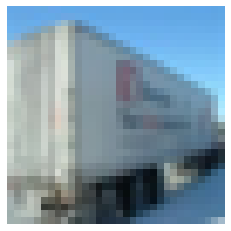

In [ ]:
show_image(x_train[15])

In [ ]:
print(y_train[15])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
data = x_train[0:1000].copy()
label = y_train[0:1000].copy()

# Ganeval-cifar10-convnet model

## Module structure
The model has 11 convolutional layers with increasing number of channels, followed by an average pooling layer on which a linear layer is applied to obtain to 10 softmax logits. The model uses BatchNorm.

## Training
The model was trained on random patches 24x24 cropped data patches. After cropping, data augumentation was used via tf.image.random_flip_left_right.

The MomentumOptimizer was used for training, with a momentum of 0.9. A decaying learning schedule was used, starting with 0.1 and decaying by a multiplicative factor of 0.1 every 10^3 epochs. The training batch size is 32.



In [7]:
import tensorflow_hub as hub

model_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
# model2 = hub.load(model_url,signature="image_classification")

In [8]:
from tensorflow.keras import Sequential
def model_def(linear=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
    model.add(hub.KerasLayer(model_url,signature="default"))
    if linear == False:
        model.add(tf.keras.layers.Activation('softmax'))
    else:
        model.add(tf.keras.layers.Activation('linear'))
    # model.add(tf.keras.layers.Activation('relu'))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4),
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=['accuracy'])
    return model

In [9]:
model = model_def(False)

In [10]:
model2 = model_def(True)

In [11]:
from art.estimators.classification import TensorFlowV2Classifier
# wrap the model an calculte emperical robustnees
wrapper2 = TensorFlowV2Classifier(model2, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=model2.loss)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 10)                7796426   
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


## Model's accuracy on train data

In [ ]:
model.evaluate(data,label)

32/32 [==============================] - 10s 316ms/step - loss: 0.0017 - accuracy: 1.0000


[0.0016680299304425716, 1.0]

In [ ]:
np.argmax(model.predict(x_train[500].reshape(1,32,32,3)))

5

## Model's accuracy on test data before evasion attacks

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 103s 328ms/step - loss: 0.0471 - accuracy: 0.9452


[0.047059524804353714, 0.9452000260353088]

creating wrapper for calling generate method of art library

In [12]:
from art.metrics import empirical_robustness
from art.estimators.classification import TensorFlowV2Classifier
# wrap the model an calculte emperical robustnees
wrapper = TensorFlowV2Classifier(model, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=model.loss)

## Checking the robustness of the model against FGSM attack

In [ ]:
print( 'robustness of the undefended model', empirical_robustness( wrapper, x_test, 'fgsm', {'eps_step':.3}))

robustness of the undefended model 0.32111713


## Trying a sample attack using FGSM method and checking the result

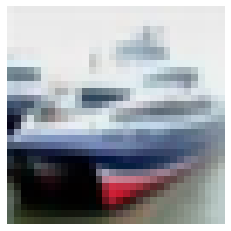

In [ ]:
show_image(x_test[1])

In [ ]:
print("Predicted Label")
print(np.argmax(model.predict(x_test[1].reshape(1,32,32,3))))
print("Actual Label")
print(np.argmax(y_test[1]))

Predicted Label
8
Actual Label
8


class prediction for the adversarial sample: 2


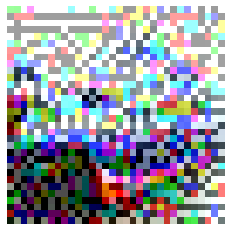

In [ ]:
from art.attacks.evasion import FastGradientMethod
fgsm = FastGradientMethod( wrapper )
x_adv = fgsm.generate(x_test[1].reshape((1,32,32,3) ))
print( 'class prediction for the adversarial sample:',
       np.argmax(model.predict( x_adv.reshape((1,32,32,3) ) ) ))
show_image( x_adv.reshape((32,32,3) ) )

# 10 instances from each class (total of 100 instances from test data) for the experiments

In [ ]:
np.__version__

'1.19.5'

In [ ]:
tf.__version__

'2.7.0'

In [13]:
#extract equal ratio of all the classes
x_test_adv, y_test_adv = extract_n_classes( x_test, y_test ,n=10)
session =  tf.compat.v1.Session()
tf.compat.v1.keras.backend.set_session( session )

In [ ]:
y_test_adv.shape, x_test_adv.shape

((100, 10), (100, 32, 32, 3))

In [ ]:
x_test.shape

(10000, 32, 32, 3)

In [ ]:
y_test_adv[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [18]:
# wrapper = TensorFlowV2Classifier(model, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=model.loss)
from art.estimators.classification import KerasClassifier
wrapper = KerasClassifier(model=model, clip_values=(0, 1), use_logits=False)

## Model accuracy on adversarial examples before adding perturbations to the examples.

In [ ]:
model.evaluate(x_test_adv,y_test_adv)

4/4 [==============================] - 1s 232ms/step - loss: 1.1921e-07 - accuracy: 0.9200


[1.1920930376163597e-07, 0.9200000166893005]

# **ATTACKS**

https://deepnotes.io/adversarial-attack

Most of the attacks are untargeted where an untargeted attack causes a model to misclassify an image to another class except for the original one. In contrast, a targeted attack causes a model to classify an image as a given target class. We want to perturb an image to maximize the probability of a class of our choosing.

# White Box Attacks

In [19]:
from sklearn.metrics import classification_report
target_names=['airplane' ,'automobile' ,'bird' ,'cat' ,'deer' ,'dog' ,'frog' ,'horse' ,'ship' ,'truck']
report=pd.DataFrame()
def evasion_attack(model,attack,name,wrapper,to_cat=True):
    # x_test_adv_evasion = x_test_adv.copy()
    if to_cat == False:
        y_test_adv_evasion = np.argmax(y_test_adv.copy(), axis=1)
    else:
        y_test_adv_evasion = y_test_adv.copy()
    print(y_test_adv_evasion.shape)
    x_test_adv_evasion = attack.generate( x_test_adv.copy() )
    metri = model.evaluate( x_test_adv_evasion, y_test_adv_evasion )
    predictions = model.predict(x_test_adv_evasion)
    print( 'accuracy on adversarial examples for {} attack is : {}'.format(name,metri[1]))
    clf = classification_report(np.argmax(y_test_adv, axis=1), 
                                   np.argmax(predictions, axis=1), 
                                   output_dict=True)
    clf = clf['weighted avg']
    clf.update({'Loss':metri[0]})
    clf.update({'Accuracy':metri[1]})
    clf.update({'Attack':name})
    return clf,x_test_adv_evasion,predictions


In [20]:
#for consolidated results
res=[]
ind=[]

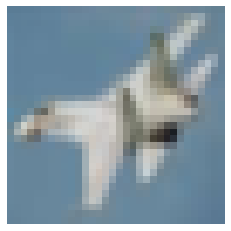

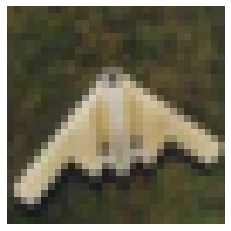

In [ ]:
show_image(x_test_adv[1])
show_image(x_test_adv[5])

# Fast Gradient Method

FGSM is a one of the simplest yet very efficient method of generating adversarial pertubations. It is a white-box method that can produce samples to cause trageted or untargeted misclassification. To find the perturbations, one can estimate the dimensions of the input space which are most sensitive to class change by calculating the gradient of the loss function with respect to the input. When the input is modified by changing the values of these dimensions in the opposite direction of the gradient, it maximizes the error of the network.

In [ ]:
from art.attacks.evasion import FastGradientMethod
#, eps_step=0.001, eps=0.01, 
fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )
clf,adv_res,pred = evasion_attack(model,fgsm,"Fast Gradient Method",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("FGSM")

(100, 10)
4/4 [==============================] - 1s 269ms/step - loss: 3.9229 - accuracy: 0.4000
accuracy on adversarial examples for Fast Gradient Method attack is : 0.4000000059604645


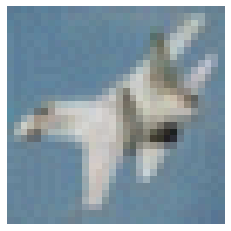

3
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))

# Auto Projected Gradient Descent (Auto-PGD)

In [ ]:
from art.attacks.evasion import AutoProjectedGradientDescent
# (estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE, norm: Union[int, float, str] = inf, eps: float = 0.3, eps_step: float = 0.1, max_iter: int = 100, targeted: bool = False, nb_random_init: int = 5, batch_size: int = 32, loss_type: Optional[str] = None, verbose: bool = True)
apgd = AutoProjectedGradientDescent(wrapper2, eps=0.1, batch_size=50, max_iter=10,targeted=False,eps_step=0.1)
clf,adv_res,pred = evasion_attack(model2,apgd,"Auto Projected Gradient Descent",wrapper2)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("AutoPGD")

(100, 10)


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 1s 274ms/step - loss: 2.9013 - accuracy: 0.2900
accuracy on adversarial examples for Auto Projected Gradient Descent attack is : 0.28999999165534973


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


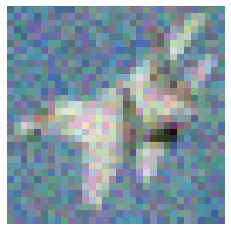

3
0


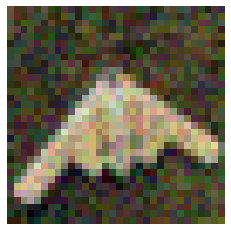

6
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

In [ ]:
# Wasserstein Attack

# Projected Gradient Descent

The Projected Gradient Descent attack is an iterative method in which, after each iteration, the perturbation is projected on an lp-ball of specified radius (in addition to clipping the values of the adversarial sample so that it lies in the permitted data range). This is the attack proposed by Madry et al. for adversarial training.

In [22]:
from art.attacks.evasion import ProjectedGradientDescent
pgd = ProjectedGradientDescent( wrapper,eps_step=0.1, eps=0.1, targeted=False,max_iter=10)
clf,adv_res,pred = evasion_attack(model,pgd,"Projected Gradient Descent",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("PGD")

(100, 10)


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

100/100 [==============================] - 1s 13ms/sample - loss: 18.7566 - acc: 0.0100
accuracy on adversarial examples for Projected Gradient Descent attack is : 0.009999999776482582


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


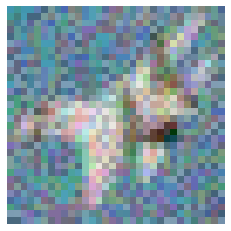

2
0


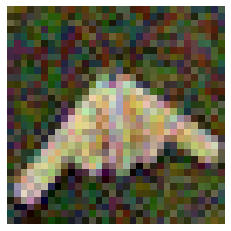

2
0


In [23]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

In [26]:
res

[{'Accuracy': 0.01,
  'Attack': 'Projected Gradient Descent',
  'Loss': 18.75661560058594,
  'f1-score': 0.01666666666666667,
  'perturbation': 0.06549544,
  'precision': 0.05,
  'recall': 0.01,
  'support': 100}]

# Newton Fool

In [ ]:
from art.attacks.evasion import NewtonFool
nf = NewtonFool( wrapper, eta=0.01, batch_size=1,max_iter=10)
clf,adv_res,pred = evasion_attack(model,nf,"Newton Fool",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("NF")

NewtonFool:   0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 1s 230ms/step - loss: 2.5701 - accuracy: 0.0400
accuracy on adversarial examples for Newton Fool attack is : 0.03999999910593033


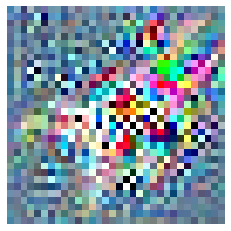

3
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))

# Elastic Net Attack

In [ ]:
from art.attacks.evasion import ElasticNet
en = ElasticNet( wrapper,max_iter=10,targeted=False,decision_rule="EN")
clf,adv_res,pred = evasion_attack(model,en,"elastic net",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("elastic net")

EAD:   0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 1s 228ms/step - loss: 3.4087 - accuracy: 0.0600
accuracy on adversarial examples for elastic net attack is : 0.05999999865889549


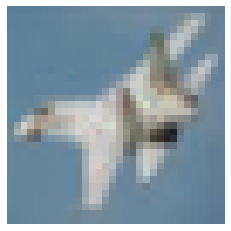

3
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))

# Carlini and Wagner L_inf Attack

This is a modified version of the L_2 optimized attack of Carlini and Wagner (2016). It controls the L_Inf norm, i.e. the maximum perturbation applied to each pixe

In [ ]:
from art.attacks.evasion import CarliniLInfMethod
clfm = CarliniLInfMethod(wrapper, confidence=0.0, targeted=False,learning_rate=0.01, 
                         max_iter=10, max_halving=15, max_doubling=15,eps=0.01,batch_size=20)
clf,adv_res,pred = evasion_attack(model,clfm,"C&W L_inf",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("C&W L_inf")

C&W L_inf:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 1s 235ms/step - loss: 0.8046 - accuracy: 0.6900
accuracy on adversarial examples for C&W L_inf attack is : 0.6899999976158142


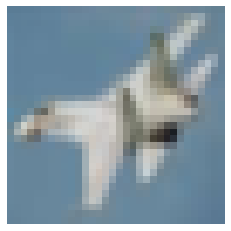

0
0


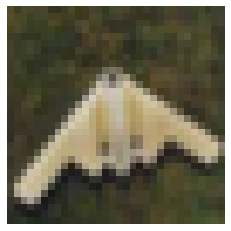

2
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# Jacobian Based Saliency Map Attack

JSMA is another gradient based whitebox method. Papernot et al. (2016)[4] proposed to use the gradient of loss with each class labels with respect to every component of the input i.e. jacobian matrix to extract the sensitivity direction. Then a saliency map is used to select the dimension which produces the maximum error 

In [ ]:
from art.attacks.evasion import SaliencyMapMethod
scm = SaliencyMapMethod(wrapper, theta=0.1, gamma=1.0, batch_size=20)
clf,adv_res,pred = evasion_attack(model,scm,"Saliency Map Method",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("Saliency Map Method")

JSMA:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 1s 236ms/step - loss: 1.2219 - accuracy: 0.0000e+00
accuracy on adversarial examples for Saliency Map Method attack is : 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


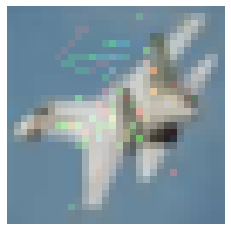

1
0


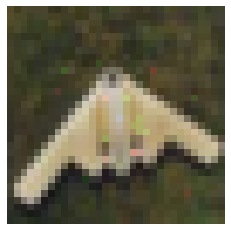

6
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# DeepFool attack

Implementation of the DeepFool algorithm from Moosavi-Dezfooli et al. (2015) to efficiently compute perturbations that fool deep networks, and thus reliably quantify the robustness of the state-of-the-art deep classifiers.

In [ ]:
from art.attacks.evasion import DeepFool
depf = DeepFool(wrapper, max_iter=100, epsilon=1e-06, nb_grads=10, batch_size=1)
clf,adv_res,pred = evasion_attack(model,depf,"Deep Fool",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("Deep Fool")

DeepFool:   0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 1s 234ms/step - loss: 6.6634 - accuracy: 0.1100
accuracy on adversarial examples for Deep Fool attack is : 0.10999999940395355


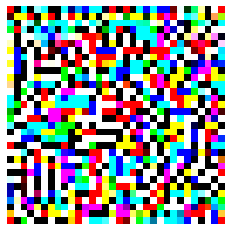

9
0


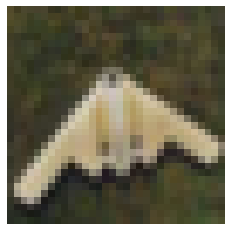

2
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# Universal Perturbation Attack

Implementation of the attack from Moosavi-Dezfooli et al. (2016). Computes a fixed perturbation to be applied to all future inputs. To this end, it can use any adversarial attack method.

In [ ]:
from art.attacks.evasion import UniversalPerturbation
upa = UniversalPerturbation(wrapper,attacker='deepfool', attacker_params=None, delta=0.2, max_iter=10, eps=10.0, norm=2)
clf,adv_res,pred = evasion_attack(model,upa,"Universal Perturbation",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("Universal Perturbation")

4/4 [==============================] - 1s 239ms/step - loss: 6.4808 - accuracy: 0.1200
accuracy on adversarial examples for Universal Perturbation attack is : 0.11999999731779099


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


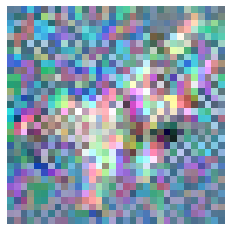

2
0


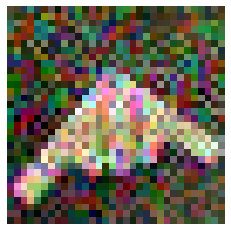

2
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# Virtual Adversarial Method

In [ ]:
from art.attacks.evasion import VirtualAdversarialMethod
vam = VirtualAdversarialMethod(wrapper, eps=0.1, batch_size=5, max_iter=1)
clf,adv_res,pred = evasion_attack(model,vam,"Virtual Adversarial Method",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("VirtualAdversarialMethod")

VAT:   0%|          | 0/20 [00:00<?, ?it/s]

4/4 [==============================] - 1s 221ms/step - loss: 0.2277 - accuracy: 0.9400
accuracy on adversarial examples for Virtual Adversarial Method attack is : 0.9399999976158142


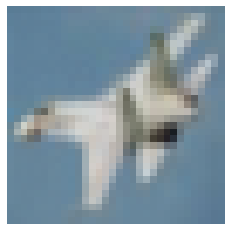

0
0


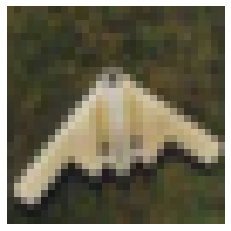

2
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# Frame Saliency Attack

The Iterative Frame Saliency attack creates adversarial examples for optical flow-based image and video classification models.

In [ ]:
from art.attacks.evasion import FrameSaliencyAttack
fsa = FrameSaliencyAttack(wrapper, batch_size=20, attacker=fgsm,method="iterative_saliency")
clf,adv_res,pred = evasion_attack(model,fsa,"Frame Saliency Attack",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("Frame Saliency Attack")

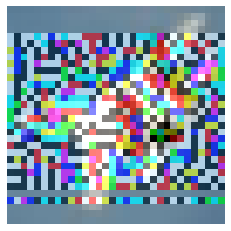

3
0


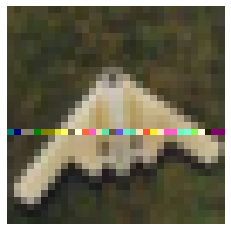

0
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# Adversarial Patch

This attack generates adversarial patches that can be printed and applied in the physical world to attack image and video classification models.

In [ ]:
!pip install tensorflow_addons

In [ ]:
model2 = model_def(True)

In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
# wrap the model an calculte emperical robustnees
wrapper2 = TensorFlowV2Classifier(model2, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=model2.loss)

In [ ]:
from art.attacks.evasion import AdversarialPatchTensorFlowV2
adpv2 = AdversarialPatchTensorFlowV2(wrapper2, patch_shape=(2,2,3),max_iter=10,batch_size=20,learning_rate=1e-3)
clf,adv_res,pred = evasion_attack(model2,adpv2,"Adversarial Patch TensorFlowV2",wrapper)
clf['perturbation'] = perturbation
res.append(clf)
ind.append("AdversarialPatchTensorFlowV2")

(100, 10)


Adversarial Patch TensorFlow v2:   0%|          | 0/10 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# Feature Adversaries

Feature Adversaries manipulates images as inputs to neural networks to mimic the intermediate representations/layers of the original images while changing its classification.

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent
pgd = ProjectedGradientDescent( wrapper,eps_step=0.001, eps=0.01, targeted=False,max_iter=10)

In [ ]:
from art.attacks.evasion import FeatureAdversariesTensorFlowV2
adpv2 = FeatureAdversariesTensorFlowV2(wrapper, max_iter=10,batch_size=20,delta=0.1,step_size=3)
# clf,adv_res,pred = evasion_attack(model2,adpv2,"Feature Adversaries TensorFlowV2",wrapper2)
attack=adpv2
# y_test_adv_evasion = np.argmax(y_test_adv.copy(), axis=1)
y_test_adv_evasion = y_test_adv.copy()
print(y_test_adv_evasion.shape,x_test_adv.shape)
x_test_adv_evasion = attack.generate( x_test_adv.copy() ,x_test_adv.copy())
metri = model2.evaluate( x_test_adv_evasion, y_test_adv_evasion )
predictions = model2.predict(x_test_adv_evasion)
print( 'accuracy on adversarial examples for {} attack is : {}'.format("Feature Adversaries TensorFlowV2",metri[1]))
clf = classification_report(np.argmax(y_test_adv, axis=1), 
                                   np.argmax(predictions, axis=1), 
                                   output_dict=True)
clf = clf['weighted avg']
clf.update({'Loss':metri[0]})
clf.update({'Accuracy':metri[1]})
clf.update({'Attack':"Feature Adversaries TensorFlowV2"})
perturbation = np.mean(np.abs((x_test_adv_evasion - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("Feature Adversaries TensorFlowV2")

(100, 10) (100, 32, 32, 3)


Feature Adversaries TensorFlow v2:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Adversaries TensorFlow v2:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Adversaries TensorFlow v2:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Adversaries TensorFlow v2:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Adversaries TensorFlow v2:   0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 1s 285ms/step - loss: 1.1921e-07 - accuracy: 0.9200
accuracy on adversarial examples for Feature Adversaries TensorFlowV2 attack is : 0.9200000166893005


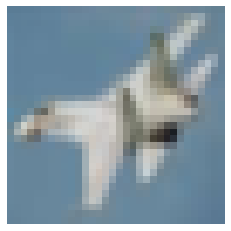

0
0


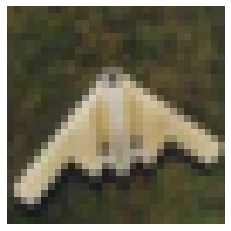

5
0


In [ ]:
show_image(x_test_adv_evasion[1])
print(np.argmax(predictions[1]))
print(np.argmax(y_test_adv_evasion[1]))
show_image(x_test_adv_evasion[5])
print(np.argmax(predictions[5]))
print(np.argmax(y_test_adv_evasion[5]))

# Black-Box Attacks

White-box attacks use gradient information of the neural networks which may not be able to an adversary in the real world situation. However, several black box attacks like surrogate models etc have shown to be quite effective in fooling networks. One of the extreme methods that demonstrates the severity of adversarial attacks is Pixel Attack.

# Hop Skip Jump 

### Implementation of the HopSkipJump attack from Jianbo et al. (2019). This is a powerful black-box attack that only requires final class prediction, and is an advanced version of the boundary attack.

In [ ]:
from art.attacks.evasion import HopSkipJump
# hsj = HopSkipJump( wrapper, max_iter=10, targeted=False)
# res.append(evasion_attack(model,hsj,"Hop Skip Jump",wrapper))
# ind.append("HSJ")
hsj = HopSkipJump( wrapper, targeted=False,max_iter=10, norm=2,
                                  max_eval=10000, init_eval=10, init_size=10)
clf,adv_res,pred = evasion_attack(model,hsj,"Hop Skip Jump",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("HSJ")
# print( 'robustness of the undefended model', 
#       empirical_robustness( wrapper, x_test_adv[:10], 'hsj', {'max_iter':10} ))

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 1s 237ms/step - loss: 2.1276 - accuracy: 0.1200
accuracy on adversarial examples for Hop Skip Jump attack is : 0.11999999731779099


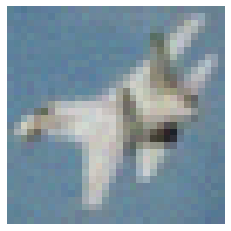

5
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))


# Spatial Transformation

Implementation of the spatial transformation attack using translation and rotation of inputs. The attack conducts black-box queries to the target model in a grid search over possible translations and rotations to find optimal attack parameters.

In [ ]:
from art.attacks.evasion import SpatialTransformation
st = SpatialTransformation( wrapper )
clf,adv_res,pred = evasion_attack(model,st,"Spatial Transformation",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("Spatial Transformation")

Spatial transformation:   0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 1s 238ms/step - loss: 0.3555 - accuracy: 0.9200
accuracy on adversarial examples for Spatial Transformation attack is : 0.9200000166893005


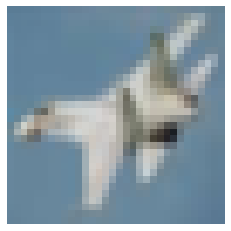

0
0


In [ ]:
# show_image(adv_res[5])
# print(np.argmax(pred[5]))
# print(np.argmax(y_test_adv[5]))
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))

# Zeroth-Order Optimization (ZOO) Attack

The black-box zeroth-order optimization attack from Pin-Yu Chen et al. (2018). This attack is a variant of the C&W attack which uses ADAM coordinate descent to perform numerical estimation of gradients.

In [ ]:
from art.attacks.evasion import ZooAttack
zoo = ZooAttack(wrapper,confidence=0.0,binary_search_steps=1, initial_const=0.001, targeted=False, learning_rate=0.01, max_iter=10, 
                abort_early=True, use_resize=True,use_importance=True, nb_parallel=128, batch_size=1, variable_h=0.0001)
clf,adv_res,pred = evasion_attack(model,zoo,"Zeroth-Order Optimization",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation


ZOO:   0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 1s 245ms/step - loss: 0.3563 - accuracy: 0.9200
accuracy on adversarial examples for Zeroth-Order Optimization attack is : 0.9200000166893005


In [ ]:
res.append(clf)
ind.append("ZOO")

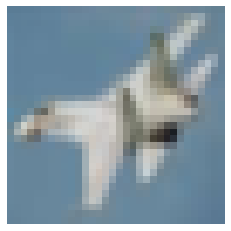

0
0


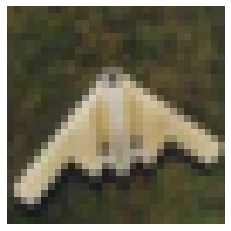

5
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# Pixel Attack

In [ ]:
from art.attacks.evasion import PixelAttack
pxl = PixelAttack( wrapper, th=None, es=1, targeted=False,max_iter=10)
clf,adv_res,pred = evasion_attack(model,pxl,"Pixel Attack",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("Pixel")

(100, 10)


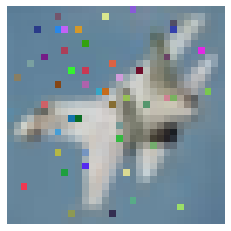

4
0


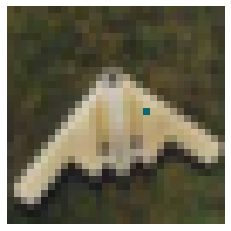

9
0


In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# Threshold Attack

In [ ]:
!python -m pip install cma

In [ ]:
from art.attacks.evasion import ThresholdAttack
ta = ThresholdAttack( wrapper )
clf,adv_res,pred = evasion_attack(model,ta,"Threshold Attack",wrapper)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("Threshold")

In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# Saving the Results

In [25]:
# rr=pd.read_csv('/content/drive/MyDrive/EvasionAttacksResults.csv')
# rr

In [ ]:
res

[{'Accuracy': 0.9200000166893005,
  'Attack': 'Feature Adversaries TensorFlowV2',
  'Loss': 1.1920930376163597e-07,
  'f1-score': 0.921540973646237,
  'perturbation': 0.0,
  'precision': 0.9301515151515152,
  'recall': 0.92,
  'support': 100},
 {'Accuracy': 0.28999999165534973,
  'Attack': 'Auto Projected Gradient Descent',
  'Loss': 2.901257276535034,
  'f1-score': 0.28491928469540406,
  'perturbation': 0.060501564,
  'precision': 0.48805137844611524,
  'recall': 0.29,
  'support': 100}]

In [ ]:
# df_new

In [ ]:
df = pd.DataFrame(res)
df_new = pd.concat([rr, df], axis =0).reset_index()
df_new

,level_0,Unnamed: 0,index,Unnamed: 0.1,precision,recall,f1-score,support,Loss,Accuracy,Attack,perturbation
0,0,0.0,0.0,0.0,0.412133,0.40,0.401318,100.0,3.922883e+00,0.40,Fast Gradient Method,0.009887
1,1,1.0,1.0,1.0,0.111111,0.12,0.081193,100.0,2.127613e+00,0.12,Hop Skip Jump,0.015916
2,2,2.0,2.0,2.0,0.143263,0.15,0.144628,100.0,9.883766e+00,0.15,Projected Gradient Descent,0.006463
3,3,3.0,3.0,3.0,0.049167,0.04,0.043611,100.0,2.570076e+00,0.04,Newton Fool,0.025163
4,4,4.0,4.0,4.0,0.062208,0.06,0.059847,100.0,3.408747e+00,0.06,elastic net,0.047407
5,5,5.0,5.0,5.0,0.930152,0.92,0.921541,100.0,3.554935e-01,0.92,Spatial Transformation,0.000000
6,6,6.0,6.0,6.0,0.926818,0.92,0.921743,100.0,3.563122e-01,0.92,Zeroth-Order Optimization,0.000004
7,7,7.0,0.0,NaN,0.412133,0.40,0.401318,100.0,3.922883e+00,0.40,Fast Gradient Method,0.009887
8,8,8.0,1.0,NaN,0.111111,0.12,0.081193,100.0,2.127613e+00,0.12,Hop Skip Jump,0.015916
9,9,9.0,2.0,NaN,0.143263,0.15,0.144628,100.0,9.883766e+00,0.15,Projected Gradient Descent,0.006463


In [ ]:
report = pd.DataFrame(df_new)
report.to_csv('/content/drive/MyDrive/EvasionAttacksResults4.csv')

# MISC

The following attacks did not work

# Shadow Attack

In [ ]:
from art.attacks.evasion import ShadowAttack
sa = ShadowAttack(wrapper, batch_size=100, nb_steps=1,targeted=False)
# clf,adv_res,pred = evasion_attack(model,sa,"Shadow Attack",wrapper)
attack=sa
# y_test_adv_evasion = np.argmax(y_test_adv.copy(), axis=1)
# x_test_adv_evasion=np.array(1)
y_test_adv_evasion = y_test_adv.copy()
print(y_test_adv_evasion.shape,x_test_adv.shape)
# x_test_adv_evasion = attack.generate( x_test_adv.copy())
x_test_adv_evasion = [attack.generate( ff.reshape((1,32,32,3))) for ff in x_test_adv.copy()]
metri = model.evaluate( x_test_adv_evasion, y_test_adv_evasion )
predictions = model.predict(x_test_adv_evasion)
print( 'accuracy on adversarial examples for {} attack is : {}'.format("Feature Adversaries TensorFlowV2",metri[1]))
clf = classification_report(np.argmax(y_test_adv, axis=1), 
                                   np.argmax(predictions, axis=1), 
                                   output_dict=True)
clf = clf['weighted avg']
clf.update({'Loss':metri[0]})
clf.update({'Accuracy':metri[1]})
clf.update({'Attack':"Feature Adversaries TensorFlowV2"})
perturbation = np.mean(np.abs((x_test_adv_evasion - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("Feature Adversaries TensorFlowV2")
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("shadow")

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# Wasserstein Attack

In [ ]:
from art.attacks.evasion import Wasserstein
wa = Wasserstein(wrapper,targeted = False, regularization = 3000.0, p = 2, kernel_size = 5, eps_step = 0.1, 
                 norm = 'wasserstein', ball = 'wasserstein', eps = 0.3, eps_iter = 10, eps_factor = 1.1, 
                 max_iter = 400, conjugate_sinkhorn_max_iter = 1, projected_sinkhorn_max_iter = 1, batch_size = 1)
clf,adv_res,pred = evasion_attack(model,wa,"Wasserstein Attack",wrapper,to_cat=False)
perturbation = np.mean(np.abs((adv_res - x_test_adv)))
clf['perturbation'] = perturbation
res.append(clf)
ind.append("Wasserstein")

(100,)


Wasserstein:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/art/attacks/evasion/wasserstein.py:388: RuntimeWarning: overflow encountered in exp
  exp_beta = np.exp(-beta)


ValueError: ignored

In [ ]:
show_image(adv_res[1])
print(np.argmax(pred[1]))
print(np.argmax(y_test_adv[1]))
show_image(adv_res[5])
print(np.argmax(pred[5]))
print(np.argmax(y_test_adv[5]))

# Even Dpatch and RobustDPatch did not work

# **Defences**

Look at the defenses that are implemented in ART. These include both preprocessor and postprocessor defense mechanisms as well as trainer, transformer, and
detector mechanisms. The postprocessor defenses are applied to the output of
the model. Just as you do with the preprocessor defenses you are to evaluate the
performance of the postprocessor defenses. You should evaluate these defenses
on the adversarial examples created earlier and provide a detailed comparison
of these defense mechanisms.

In [ ]:
res_def = []

In [ ]:
from art.attacks.evasion import FastGradientMethod

# **Pre-Processor**

# Feature Squeezing

Feature Squeezing: A general framework that reduces the search space available for an adversary and detects adversarial examples.

In [ ]:
from art.defences.preprocessor import FeatureSqueezing
fes = FeatureSqueezing(clip_values = (0.,0.2), bit_depth = 4, apply_fit = True, apply_predict = False)


In [ ]:
# fes.fit( x_train, y_train, batch_size=100, nb_epochs=5 )

In [ ]:
x_new_def,y_new_def = fes.__call__(x=x_train,y=y_train)

In [ ]:
defended_model = model_def()

In [ ]:
defended_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (None, 10)                7796426   
_________________________________________________________________
activation_8 (Activation)    (None, 10)                0         
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [ ]:
np.sum(x_new_def != x_train)

143475833

In [ ]:
defended_model.fit(x_new_def,y_new_def)

1563/1563 [==============================] - 588s 376ms/step - loss: 0.0019 - accuracy: 0.9999


In [ ]:
# adversarial_tranier = AdversarialTrainer( defended_model, fgsm )
from art.attacks.evasion import FastGradientMethod
fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )
# and now on adversarial examples
x_test_adv_def = fgsm.generate( x_test_adv )
# acc =  wrapper_def._model.evaluate( x_test_adv_def, y_test_adv )
acc = defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

4/4 [==============================] - 1s 274ms/step - loss: 2.7515 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [2.7515037059783936, 0.4000000059604645]


In [ ]:
res_def.append({"name":"Feature Squezzing","accuracy":acc[1],"loss":acc[0]})

In [ ]:
from art.attacks.evasion import SaliencyMapMethod
scm = SaliencyMapMethod(wrapper, theta=0.1, gamma=1.0, batch_size=20)
x_test_adv_def = scm.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

JSMA:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 1s 272ms/step - loss: 1.2387 - accuracy: 0.0100
loss and accuracy on adversarial examples:  [1.2387489080429077, 0.009999999776482582]


In [ ]:
res_def.append({"name":"Feature Squezzing - Saliency Map Method","accuracy":acc[1],"loss":acc[0]})

In [ ]:
from art.attacks.evasion import NewtonFool
nf = NewtonFool( wrapper, eta=0.01, batch_size=1,max_iter=10)
x_test_adv_def = nf.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

NewtonFool:   0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 1s 269ms/step - loss: 2.5701 - accuracy: 0.0400
loss and accuracy on adversarial examples:  [2.5700762271881104, 0.03999999910593033]


In [ ]:
res_def.append({"name":"Feature Squezzing - Newton Fool","accuracy":acc[1],"loss":acc[0]})

In [ ]:
from art.attacks.evasion import ElasticNet
en = ElasticNet( wrapper,max_iter=10,targeted=False,decision_rule="EN")
x_test_adv_def = en.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

EAD:   0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 1s 269ms/step - loss: 3.4087 - accuracy: 0.0600
loss and accuracy on adversarial examples:  [3.4087471961975098, 0.05999999865889549]


In [ ]:
res_def.append({"name":"Feature Squezzing - Elastic Net","accuracy":acc[1],"loss":acc[0]})

In [ ]:
res_def

[{'accuracy': 0.4000000059604645,
  'loss': 3.9273157119750977,
  'name': 'Feature Squezzing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Gaussian Data Augmentation'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Gaussian Data Augmentation on PGD'},
 {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Label Smoothing '},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing on PGD'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Total Variance Minimization'},
 {'accuracy': 0.019999999552965164,
  'loss': 1.2184207439422607,
  'name': 'Spatial Smoothing - Saliency Map Attack'},
 {'accuracy': 0.009999999776482582,
  'loss': 1.2387489080429077,
  'name': 'Feature Sq

# Gaussian Data Augmentation¶


Feature Squeezing: A general framework that reduces the search space available for an adversary and detects adversarial examples.

In [ ]:
from art.defences.preprocessor import GaussianAugmentation
gas = GaussianAugmentation(sigma=0.05, augmentation=True, ratio=0.5, clip_values=(0.,255.), apply_fit=True, apply_predict=False)


In [ ]:
# fes.fit( x_train, y_train, batch_size=100, nb_epochs=5 )

In [ ]:
x_new_def,y_new_def = gas.__call__(x=x_train,y=y_train)

In [ ]:
defended_model = model_def()

In [ ]:
defended_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 10)                7796426   
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [ ]:
np.sum(x_new_def == x_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


0

In [ ]:
defended_model.fit(x_new_def,y_new_def)

2344/2344 [==============================] - 893s 380ms/step - loss: 0.4311 - accuracy: 0.9016


In [ ]:
wrapper_def = TensorFlowV2Classifier(defended_model, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=defended_model.loss)

fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )
# and now on adversarial examples
x_test_adv_def = fgsm.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

4/4 [==============================] - 1s 275ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
res_def.append({"name":"Gaussian Data Augmentation","accuracy":acc[1],"loss":acc[0]})

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent
pgd = ProjectedGradientDescent( wrapper,eps_step=0.001, eps=0.01, targeted=False,max_iter=10)
x_test_adv_def = pgd.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )

PGD - Batches: 0it [00:00, ?it/s]

4/4 [==============================] - 1s 276ms/step - loss: 9.8838 - accuracy: 0.1500


In [ ]:
print( 'loss and accuracy on adversarial examples: ', acc )

loss and accuracy on adversarial examples:  [9.883766174316406, 0.15000000596046448]


In [ ]:
res_def.append({"name":"Gaussian Data Augmentation on PGD","accuracy":acc[1],"loss":acc[0]})

In [ ]:
res_def

[{'accuracy': 0.4000000059604645,
  'loss': 3.9273157119750977,
  'name': 'Feature Squezzing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Gaussian Data Augmentation'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Gaussian Data Augmentation on PGD'}]

# JPEG Compression

In [ ]:
from art.defences.preprocessor import JpegCompression
jpeg = JpegCompression(clip_values=(0.,255.), quality = 95, 
                       channels_first = True, apply_fit = True, 
                       apply_predict = True)


In [ ]:
x_new_def,y_new_def = jpeg.__call__(x=x_train,y=y_train)

In [ ]:
defended_model = model_def()

In [ ]:
x_new_def.shape

(50000, 32, 32, 3)

In [ ]:
defended_model.fit(x_new_def,y_new_def)

1563/1563 [==============================] - 598s 382ms/step - loss: 8.4528 - accuracy: 0.1155


In [ ]:
# wrapper_def = TensorFlowV2Classifier(defended_model, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=defended_model.loss)

fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )
# and now on adversarial examples
x_test_adv_def = fgsm.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

4/4 [==============================] - 1s 288ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
res_def.append({"name":"JPEG ","accuracy":acc[1],"loss":acc[0]})

# Label Smoothing

In [ ]:
from art.defences.preprocessor import LabelSmoothing
lbsm = LabelSmoothing(max_value = 0.9, apply_fit = True, apply_predict = False)


In [ ]:
x_new_def,y_new_def = lbsm.__call__(x=x_train,y=y_train)

In [ ]:
defended_model = model_def()

In [ ]:
x_new_def.shape

(50000, 32, 32, 3)

In [ ]:
defended_model.fit(x_new_def,y_new_def)

1563/1563 [==============================] - 633s 404ms/step - loss: 1.2624 - accuracy: 1.0000


In [ ]:
defended_model.evaluate(x_test[1:1000],y_test[1:1000])

32/32 [==============================] - 12s 388ms/step - loss: 0.2087 - accuracy: 0.9459


[0.20868916809558868, 0.9459459185600281]

In [ ]:
# wrapper_def = TensorFlowV2Classifier(defended_model, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=defended_model.loss)

fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )
# and now on adversarial examples
x_test_adv_def = fgsm.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

4/4 [==============================] - 2s 301ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
res_def.append({"name":"Label Smoothing ","accuracy":acc[1],"loss":acc[0]})

In [ ]:
res_def

[{'accuracy': 0.4000000059604645,
  'loss': 3.9273157119750977,
  'name': 'Feature Squezzing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Gaussian Data Augmentation'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Gaussian Data Augmentation on PGD'},
 {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Label Smoothing '}]

# Resample

Not applicable as it is for audio

In [ ]:
from art.defences.preprocessor import Resample
resamp = Resample(sr_original = 5 , sr_new = 5, channels_first = False, apply_fit = False, apply_predict = True)


In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
x_new_def,y_new_def = resamp.__call__(x=x_train,y=y_train)

ValueError: ignored

In [ ]:
defended_model = model_def()

In [ ]:
x_new_def.shape

(50000, 32, 32, 3)

In [ ]:
defended_model.fit(x_new_def,y_new_def)

1563/1563 [==============================] - 633s 404ms/step - loss: 1.2624 - accuracy: 1.0000


In [ ]:
defended_model.evaluate(x_test[1:1000],y_test[1:1000])

32/32 [==============================] - 12s 388ms/step - loss: 0.2087 - accuracy: 0.9459


[0.20868916809558868, 0.9459459185600281]

In [ ]:
# wrapper_def = TensorFlowV2Classifier(defended_model, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=defended_model.loss)

fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )
# and now on adversarial examples
x_test_adv_def = fgsm.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

4/4 [==============================] - 2s 301ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
res_def.append({"name":"Label Smoothing ","accuracy":acc[1],"loss":acc[0]})

In [ ]:
res_def

[{'accuracy': 0.4000000059604645,
  'loss': 3.9273157119750977,
  'name': 'Feature Squezzing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Gaussian Data Augmentation'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Gaussian Data Augmentation on PGD'},
 {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Label Smoothing '}]

# Spatial Smoothing

In [ ]:
res_def = [{'accuracy': 0.4000000059604645,
  'loss': 3.9273157119750977,
  'name': 'Feature Squezzing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Gaussian Data Augmentation'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Gaussian Data Augmentation on PGD'},
 {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Label Smoothing '}]

In [ ]:
!pip install tensorflow_addons

In [ ]:
from art.defences.preprocessor import SpatialSmoothing
sstv = SpatialSmoothing(window_size = 3, channels_first = False, 
                                    clip_values = (0.,1.), 
                                    apply_fit = False, apply_predict = True)


In [ ]:
x_new_def,y_new_def = sstv.__call__(x=x_train,y=y_train)

In [ ]:
defended_model = model_def()

In [ ]:
defended_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 10)                7796426   
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [ ]:
np.sum(x_new_def != x_train)

98373634

In [ ]:
defended_model.fit(x_new_def,y_new_def)

1563/1563 [==============================] - 588s 375ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# wrapper_def = TensorFlowV2Classifier(defended_model, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=defended_model.loss)

fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )
# and now on adversarial examples
x_test_adv_def = fgsm.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

4/4 [==============================] - 1s 266ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
res_def.append({"name":"Spatial Smoothing","accuracy":acc[1],"loss":acc[0]})

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent
pgd = ProjectedGradientDescent( wrapper,eps_step=0.001, eps=0.01, targeted=False,max_iter=10)
x_test_adv_def = pgd.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )

PGD - Batches: 0it [00:00, ?it/s]

4/4 [==============================] - 1s 265ms/step - loss: 9.8838 - accuracy: 0.1500


In [ ]:
print( 'loss and accuracy on adversarial examples: ', acc )

loss and accuracy on adversarial examples:  [9.883766174316406, 0.15000000596046448]


In [ ]:
res_def.append({"name":"Spatial Smoothing on PGD","accuracy":acc[1],"loss":acc[0]})

In [ ]:
from art.attacks.evasion import SaliencyMapMethod
scm = SaliencyMapMethod(wrapper, theta=0.1, gamma=1.0, batch_size=20)
x_test_adv_def = scm.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )

JSMA:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 1s 268ms/step - loss: 1.2184 - accuracy: 0.0200


In [ ]:
res_def.append({"name":"Spatial Smoothing - Saliency Map Attack","accuracy":acc[1],"loss":acc[0]})

In [ ]:
res_def

[{'accuracy': 0.4000000059604645,
  'loss': 3.9273157119750977,
  'name': 'Feature Squezzing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Gaussian Data Augmentation'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Gaussian Data Augmentation on PGD'},
 {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Label Smoothing '},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing on PGD'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Total Variance Minimization'},
 {'accuracy': 0.019999999552965164,
  'loss': 1.2184207439422607,
  'name': 'Spatial Smoothing - Saliency Map Attack'}]

# ThermometerEncoding

In [ ]:
# res_def = [{'accuracy': 0.4000000059604645,
#   'loss': 3.9273157119750977,
#   'name': 'Feature Squezzing'},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Gaussian Data Augmentation'},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Gaussian Data Augmentation on PGD'},
#  {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Label Smoothing '}]

In [ ]:
!pip install tensorflow_addons

In [ ]:
from art.defences.preprocessor import ThermometerEncoding
thenc = ThermometerEncoding(clip_values = (0.,1.), num_space = 10, 
                            channels_first = False, apply_fit = True, 
                            apply_predict = False)


In [ ]:
x_new_def,y_new_def = thenc.__call__(x=x_train,y=y_train)

In [ ]:
defended_model = model_def()

In [ ]:
defended_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 10)                7796426   
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [ ]:
np.sum(x_new_def != x_train)

98373634

In [ ]:
defended_model.fit(x_new_def,y_new_def)

1563/1563 [==============================] - 576s 368ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# wrapper_def = TensorFlowV2Classifier(defended_model, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=defended_model.loss)

fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )
# and now on adversarial examples
x_test_adv_def = fgsm.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

4/4 [==============================] - 1s 266ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
res_def.append({"name":"Spatial Smoothing","accuracy":acc[1],"loss":acc[0]})

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent
pgd = ProjectedGradientDescent( wrapper,eps_step=0.001, eps=0.01, targeted=False,max_iter=10)
x_test_adv_def = pgd.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )

PGD - Batches: 0it [00:00, ?it/s]

4/4 [==============================] - 1s 265ms/step - loss: 9.8838 - accuracy: 0.1500


In [ ]:
print( 'loss and accuracy on adversarial examples: ', acc )

loss and accuracy on adversarial examples:  [9.883766174316406, 0.15000000596046448]


In [ ]:
res_def.append({"name":"Spatial Smoothing on PGD","accuracy":acc[1],"loss":acc[0]})

In [ ]:
res_def

[{'accuracy': 0.4000000059604645,
  'loss': 3.9273157119750977,
  'name': 'Feature Squezzing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Gaussian Data Augmentation'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Gaussian Data Augmentation on PGD'},
 {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Label Smoothing '},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing on PGD'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing'}]

# Total Variance Minimization

In [ ]:
res_def = [{'accuracy': 0.4000000059604645,
  'loss': 3.9273157119750977,
  'name': 'Feature Squezzing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Gaussian Data Augmentation'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Gaussian Data Augmentation on PGD'},
 {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Label Smoothing '},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing on PGD'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing'}]

In [ ]:
!pip install tensorflow_addons

In [ ]:
from art.defences.preprocessor import TotalVarMin
thenc = TotalVarMin(prob = 0.3, norm = 2, lamb = 0.5, solver = 'L-BFGS-B', 
                    max_iter = 10, clip_values = (0.,1.), apply_fit = True, apply_predict = False)


In [ ]:
x_new_def,y_new_def = thenc.__call__(x=x_train,y=y_train)

In [ ]:
defended_model = model_def()

In [ ]:
defended_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 10)                7796426   
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [ ]:
np.sum(x_new_def != x_train)

153548106

In [ ]:
defended_model.fit(x_new_def,y_new_def)

1563/1563 [==============================] - 585s 374ms/step - loss: 4.6040 - accuracy: 0.2630


In [ ]:
# wrapper_def = TensorFlowV2Classifier(defended_model, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=defended_model.loss)

fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )
# and now on adversarial examples
x_test_adv_def = fgsm.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

4/4 [==============================] - 1s 270ms/step - loss: 3.9229 - accuracy: 0.4000
loss and accuracy on adversarial examples:  [3.9228830337524414, 0.4000000059604645]


In [ ]:
np.argmax(defended_model.predict(x_test_adv_def),axis=1)

array([9, 3, 3, 6, 8, 2, 4, 1, 2, 0, 5, 9, 1, 8, 1, 1, 1, 1, 1, 3, 5, 8,
       2, 2, 8, 2, 7, 1, 2, 3, 5, 5, 6, 5, 3, 9, 5, 3, 5, 2, 0, 5, 8, 7,
       4, 3, 7, 4, 6, 0, 3, 5, 3, 5, 4, 5, 3, 3, 3, 5, 6, 3, 4, 6, 6, 2,
       2, 3, 2, 6, 7, 2, 7, 7, 5, 3, 7, 4, 7, 3, 0, 1, 6, 8, 6, 8, 8, 8,
       0, 8, 9, 9, 9, 1, 9, 9, 9, 0, 6, 9])

In [ ]:
res_def.append({"name":"Total Variance Minimization","accuracy":acc[1],"loss":acc[0]})

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent
pgd = ProjectedGradientDescent( wrapper,eps_step=0.001, eps=0.01, targeted=False,max_iter=10)
x_test_adv_def = pgd.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )

PGD - Batches: 0it [00:00, ?it/s]

4/4 [==============================] - 1s 265ms/step - loss: 9.8838 - accuracy: 0.1500


In [ ]:
print( 'loss and accuracy on adversarial examples: ', acc )

loss and accuracy on adversarial examples:  [9.883766174316406, 0.15000000596046448]


In [ ]:
res_def.append({"name":"Spatial Smoothing on PGD","accuracy":acc[1],"loss":acc[0]})

In [ ]:
res_def

[{'accuracy': 0.4000000059604645,
  'loss': 3.9273157119750977,
  'name': 'Feature Squezzing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Gaussian Data Augmentation'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Gaussian Data Augmentation on PGD'},
 {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Label Smoothing '},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing on PGD'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Total Variance Minimization'},
 {'accuracy': 0.019999999552965164,
  'loss': 1.2184207439422607,
  'name': 'Spatial Smoothing - Saliency Map Attack'},
 {'accuracy': 0.009999999776482582,
  'loss': 1.2387489080429077,
  'name': 'Feature Sq

In [ ]:
# res_def = [{'accuracy': 0.4000000059604645,
#   'loss': 3.9273157119750977,
#   'name': 'Feature Squezzing'},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Gaussian Data Augmentation'},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Gaussian Data Augmentation on PGD'},
#  {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Label Smoothing '},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Spatial Smoothing on PGD'},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Spatial Smoothing'},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Total Variance Minimization'},
#  {'accuracy': 0.019999999552965164,
#   'loss': 1.2184207439422607,
#   'name': 'Spatial Smoothing - Saliency Map Attack'},
#  {'accuracy': 0.009999999776482582,
#   'loss': 1.2387489080429077,
#   'name': 'Feature Squezzing - Saliency Map Method'}]

# **Post- Processor**

Building a custom model to facilitate post-processing defense.

In [ ]:
from keras import backend as K 
from keras.layers import Layer
class MyCustomLayer(Layer): 
   def __init__(self, output_dim, **kwargs): 
      from art.defences.postprocessor import ClassLabels
      self.clslabl = ClassLabels(apply_fit = False, apply_predict = True)
      self.output_dim = output_dim 
      super(MyCustomLayer, self).__init__(**kwargs) 
   def build(self, input_shape):
    #   print("In build--------------")
      self.add_weight(name = 'kernel', 
      shape = (input_shape[1], self.output_dim), 
      initializer = 'normal', trainable = True) 
      super(MyCustomLayer, self).build(input_shape) # 
    #   Be sure to call this at the end 
   def call(self, input_data): 
       print("In call--------------")
       with tf.compat.v1.Session().as_default() as sess:
        print(input_data.eval())
    #    input_data = tf.make_tensor_proto(input_data)
    #    input_data = tf.make_tensor_proto(input_data)
    #    input_data = tf.make_ndarray(input_data)
       idx = clslabl(input_data)
       print(idx)
    #    idx = to_categorical(idx, 10)
       return idx
   def compute_output_shape(self, input_shape): 
       return (input_shape[0], self.output_dim)

In [ ]:
def model_def_custom(linear=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
    model.add(hub.KerasLayer(model_url,signature="default"))
    if linear == False:
        model.add(tf.keras.layers.Activation('softmax'))
    else:
        model.add(tf.keras.layers.Activation('linear'))
    # model.add(tf.keras.layers.Activation('relu'))
    model.add(MyCustomLayer(10, input_shape = (1,10))) 
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4),
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=['accuracy'])
    return model

In [ ]:
# res_def

In [ ]:
res_def = []

In [ ]:
!pip install tensorflow_addons

In [ ]:
from art.defences.postprocessor import ClassLabels
clslabl = ClassLabels(apply_fit = False, apply_predict = True)


In [ ]:
defended_model = model_def_custom(True)

In call--------------


InvalidArgumentError: ignored

In [ ]:
pred = defended_model.predict(x_test[0].reshape(1,32,32,3))

In call--------------
Tensor("sequential_13/keras_layer_13/StatefulPartitionedCall:0", shape=(None, 10), dtype=float32)


In [ ]:
pred

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
clslabl(pred)

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
defended_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_16 (KerasLayer)  (None, 10)               7796426   
                                                                 
 activation_22 (Activation)  (None, 10)                0         
                                                                 
 my_custom_layer_5 (MyCustom  (1, 10)                  100       
 Layer)                                                          
                                                                 
Total params: 7,796,526
Trainable params: 100
Non-trainable params: 7,796,426
_________________________________________________________________


In [ ]:
np.argmax(defended_model.predict(x_test[1].reshape(1,32,32,3)),axis=1)

array([8])

In [ ]:
clslabl(defended_model.predict(x_test[1].reshape(1,32,32,3)))

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
defended_model.evaluate(x_test[1:10],y_test[1:10])

Tensor("sequential_15/keras_layer_15/StatefulPartitionedCall:0", shape=(None, 10), dtype=float32)
Tensor("sequential_15/keras_layer_15/StatefulPartitionedCall:0", shape=(None, 10), dtype=float32)
1/1 [==============================] - 0s 305ms/step - loss: 14.3272 - accuracy: 0.1111


[14.32719612121582, 0.1111111119389534]

In [ ]:
defended_model.fit(x_new_def,y_new_def)

1563/1563 [==============================] - 585s 374ms/step - loss: 4.6040 - accuracy: 0.2630


In [ ]:
# wrapper_def = TensorFlowV2Classifier(defended_model, clip_values=(0., 1.),nb_classes=10,input_shape=(32,32,3) ,loss_object=defended_model.loss)

fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )
# and now on adversarial examples
x_test_adv_def = fgsm.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )
print( 'loss and accuracy on adversarial examples: ', acc )

4/4 [==============================] - 0s 4ms/step - loss: 14.5063 - accuracy: 0.1000
loss and accuracy on adversarial examples:  [14.50628662109375, 0.10000000149011612]


In [ ]:
np.argmax(defended_model.predict(x_test_adv_def),axis=1)

array([9, 3, 3, 6, 8, 2, 4, 1, 2, 0, 5, 9, 1, 8, 1, 1, 1, 1, 1, 3, 5, 8,
       2, 2, 8, 2, 7, 1, 2, 3, 5, 5, 6, 5, 3, 9, 5, 3, 5, 2, 0, 5, 8, 7,
       4, 3, 7, 4, 6, 0, 3, 5, 3, 5, 4, 5, 3, 3, 3, 5, 6, 3, 4, 6, 6, 2,
       2, 3, 2, 6, 7, 2, 7, 7, 5, 3, 7, 4, 7, 3, 0, 1, 6, 8, 6, 8, 8, 8,
       0, 8, 9, 9, 9, 1, 9, 9, 9, 0, 6, 9])

In [ ]:
res_def.append({"name":"Total Variance Minimization","accuracy":acc[1],"loss":acc[0]})

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent
pgd = ProjectedGradientDescent( wrapper,eps_step=0.001, eps=0.01, targeted=False,max_iter=10)
x_test_adv_def = pgd.generate( x_test_adv )
acc =  defended_model.evaluate( x_test_adv_def, y_test_adv )

PGD - Batches: 0it [00:00, ?it/s]

4/4 [==============================] - 1s 265ms/step - loss: 9.8838 - accuracy: 0.1500


In [ ]:
print( 'loss and accuracy on adversarial examples: ', acc )

loss and accuracy on adversarial examples:  [9.883766174316406, 0.15000000596046448]


In [ ]:
res_def.append({"name":"Spatial Smoothing on PGD","accuracy":acc[1],"loss":acc[0]})

In [ ]:
res_def

[{'accuracy': 0.4000000059604645,
  'loss': 3.9273157119750977,
  'name': 'Feature Squezzing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Gaussian Data Augmentation'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Gaussian Data Augmentation on PGD'},
 {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Label Smoothing '},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing on PGD'},
 {'accuracy': 0.15000000596046448,
  'loss': 9.883766174316406,
  'name': 'Spatial Smoothing'},
 {'accuracy': 0.4000000059604645,
  'loss': 3.9228830337524414,
  'name': 'Total Variance Minimization'},
 {'accuracy': 0.019999999552965164,
  'loss': 1.2184207439422607,
  'name': 'Spatial Smoothing - Saliency Map Attack'},
 {'accuracy': 0.009999999776482582,
  'loss': 1.2387489080429077,
  'name': 'Feature Sq

In [ ]:
# res_def = [{'accuracy': 0.4000000059604645,
#   'loss': 3.9273157119750977,
#   'name': 'Feature Squezzing'},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Gaussian Data Augmentation'},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Gaussian Data Augmentation on PGD'},
#  {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Label Smoothing '},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Spatial Smoothing on PGD'},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Spatial Smoothing'},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Total Variance Minimization'},
#  {'accuracy': 0.019999999552965164,
#   'loss': 1.2184207439422607,
#   'name': 'Spatial Smoothing - Saliency Map Attack'},
#  {'accuracy': 0.009999999776482582,
#   'loss': 1.2387489080429077,
#   'name': 'Feature Squezzing - Saliency Map Method'}]

# **Adversarial Training**

In [ ]:
# res_def = 

In [ ]:
!pip install tensorflow_addons

In [ ]:
defended_model = model_def()

In [ ]:
defended_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 10)                7796426   
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [ ]:
from art.attacks.evasion import FastGradientMethod
#, eps_step=0.001, eps=0.01, 
fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )

In [ ]:
from art.defences.trainer import AdversarialTrainer
adtrain = AdversarialTrainer(classifier = defended_model,
                           attacks = fgsm, ratio = 0.001)


In [ ]:
adtrain.fit(x_train, y_train, batch_size = 20)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
x_test_adv_def = fgsm.generate( x_test_adv )

In [ ]:
preds_adt = adtrain.predict(x_test_adv_def)

In [ ]:
preds_adt = np.argmax(preds_adt,axis=1)

In [ ]:
from sklearn.metrics import classification_report
ad_clf_rep = classification_report(preds_adt, np.argmax(y_test_adv,axis=1))
print(ad_clf_rep)

              precision    recall  f1-score   support

           0       0.10      0.17      0.12         6
           1       0.60      0.60      0.60        10
           2       0.40      0.36      0.38        11
           3       0.20      0.12      0.15        16
           4       0.20      0.33      0.25         6
           5       0.40      0.31      0.35        13
           6       0.40      0.40      0.40        10
           7       0.50      0.62      0.56         8
           8       0.50      0.50      0.50        10
           9       0.70      0.70      0.70        10

    accuracy                           0.40       100
   macro avg       0.40      0.41      0.40       100
weighted avg       0.41      0.40      0.40       100



In [ ]:
res_def

In [ ]:
# res_def = [{'accuracy': 0.4000000059604645,
#   'loss': 3.9273157119750977,
#   'name': 'Feature Squezzing'},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Gaussian Data Augmentation'},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Gaussian Data Augmentation on PGD'},
#  {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Label Smoothing '},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Spatial Smoothing on PGD'},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Spatial Smoothing'},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Total Variance Minimization'},
#  {'accuracy': 0.019999999552965164,
#   'loss': 1.2184207439422607,
#   'name': 'Spatial Smoothing - Saliency Map Attack'},
#  {'accuracy': 0.009999999776482582,
#   'loss': 1.2387489080429077,
#   'name': 'Feature Squezzing - Saliency Map Method'}]

# **Adversarial Training**

In [ ]:
# res_def = 

In [ ]:
!pip install tensorflow_addons

In [ ]:
defended_model = model_def()

In [ ]:
defended_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 10)                7796426   
                                                                 
 activation_3 (Activation)   (None, 10)                0         
                                                                 
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [ ]:
from art.attacks.evasion import FastGradientMethod
#, eps_step=0.001, eps=0.01, 
fgsm = FastGradientMethod( wrapper,targeted=False,eps_step=0.001, eps=0.01 )

In [ ]:
from art.defences.trainer import AdversarialTrainer
adtrain = AdversarialTrainer(classifier = defended_model,
                           attacks = fgsm, ratio = 0.1)


In [ ]:
adtrain.fit(x_train, y_train, batch_size = 20)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
x_test_adv_def = fgsm.generate( x_test_adv )

In [ ]:
preds_adt = adtrain.predict(x_test_adv_def)
preds_adt = np.argmax(preds_adt,axis=1)

In [ ]:
model.evaluate(x_test_adv_def,y_test_adv)

4/4 [==============================] - 1s 212ms/step - loss: 3.9229 - accuracy: 0.4000


[3.9228835105895996, 0.4000000059604645]

In [ ]:
from sklearn.metrics import classification_report
ad_clf_rep = classification_report(preds_adt, np.argmax(y_test_adv,axis=1))
print(ad_clf_rep)

              precision    recall  f1-score   support

           0       0.10      0.17      0.12         6
           1       0.60      0.60      0.60        10
           2       0.40      0.36      0.38        11
           3       0.20      0.12      0.15        16
           4       0.20      0.33      0.25         6
           5       0.40      0.31      0.35        13
           6       0.40      0.40      0.40        10
           7       0.50      0.62      0.56         8
           8       0.50      0.50      0.50        10
           9       0.70      0.70      0.70        10

    accuracy                           0.40       100
   macro avg       0.40      0.41      0.40       100
weighted avg       0.41      0.40      0.40       100



In [ ]:
res_def

In [ ]:
# res_def = [{'accuracy': 0.4000000059604645,
#   'loss': 3.9273157119750977,
#   'name': 'Feature Squezzing'},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Gaussian Data Augmentation'},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Gaussian Data Augmentation on PGD'},
#  {'accuracy': 0.4000000059604645, 'loss': 3.9228830337524414, 'name': 'JPEG '},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Label Smoothing '},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Spatial Smoothing on PGD'},
#  {'accuracy': 0.15000000596046448,
#   'loss': 9.883766174316406,
#   'name': 'Spatial Smoothing'},
#  {'accuracy': 0.4000000059604645,
#   'loss': 3.9228830337524414,
#   'name': 'Total Variance Minimization'},
#  {'accuracy': 0.019999999552965164,
#   'loss': 1.2184207439422607,
#   'name': 'Spatial Smoothing - Saliency Map Attack'},
#  {'accuracy': 0.009999999776482582,
#   'loss': 1.2387489080429077,
#   'name': 'Feature Squezzing - Saliency Map Method'}]

# **Evasion attacks on Text**

In [ ]:
# This model training code is directly from:
# https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py

'''Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
# Notes
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [ ]:
print('Build model...')
model_imdb = Sequential()
model_imdb.add(Embedding(max_features, 128))
model_imdb.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_imdb.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model_imdb.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model_imdb.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test, y_test))
score, acc = model_imdb.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Epoch 1/5
782/782 [==============================] - 245s 310ms/step - loss: 0.4355 - accuracy: 0.7948 - val_loss: 0.3587 - val_accuracy: 0.8419
Epoch 2/5
782/782 [==============================] - 243s 311ms/step - loss: 0.2533 - accuracy: 0.8990 - val_loss: 0.3770 - val_accuracy: 0.8390
Epoch 3/5
782/782 [==============================] - 245s 313ms/step - loss: 0.1658 - accuracy: 0.9374 - val_loss: 0.5200 - val_accuracy: 0.8272
Epoch 4/5
782/782 [==============================] - 243s 311ms/step - loss: 0.1086 - accuracy: 0.9611 - val_loss: 0.5250 - val_accuracy: 0.8228
Epoch 5/5
782/782 [==============================] - 26s 33ms/step - loss: 0.7274 - accuracy: 0.8180
Test score: 0.7274217009544373
Test accuracy: 0.8180000185966492


In [ ]:
model_imdb.save("/content/drive/MyDrive/imdb_model")

In [ ]:
from keras.models import load_model
model_imdb = load_model('/content/drive/MyDrive/imdb_model')

In [ ]:
x_test.shape,y_test.shape

((25000, 80), (25000,))

In [ ]:
sam_1 = x_test[y_test==1]

In [ ]:
sam_0 = x_test[y_test==0]

In [ ]:
sam_1.shape,sam_0.shape

((12500, 80), (12500, 80))

In [ ]:
x_text_test = np.concatenate((sam_0[0:100], sam_1[0:100]), axis=0)

In [ ]:
jj = np.zeros(100,dtype=int)
jk = np.ones(100,dtype=int)

In [ ]:
y_text_test = np.concatenate((jj,jk),axis=0)

In [ ]:
x_text_test.shape,y_text_test.shape

((200, 80), (200,))

In [ ]:
# model_imdb = Sequential()
# model_imdb.add(Embedding(max_features, 128))
# model_imdb.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# model_imdb.add(Dense(1, activation='sigmoid'))

In [ ]:
x_text_test.shape

(200, 80)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.enable_eager_execution() #This will enable eager execution which is must.

tf.executing_eagerly() #check if eager execution is enabled or not. Should give "True"

data = x_text_test
#My data is in the from of dataframe with 127549 rows and 5 columns(127549*5)

# a = data[:100]  #shape is (20,5)
# b = data[100:] # shape is (20,5)
# A = [a,b]  # making a list
# A = np.array(data) # convert into array size (2,20,5) 

At = tf.Variable(tf.convert_to_tensor(data, np.float32)) #convert into tensor
At.shape # TensorShape([Dimension(2), Dimension(20), Dimension(5)])

model = model_imdb # Load the trained model
# I have a trained model which is shown in the question above. 
# Output of this model is a single value
with tf.GradientTape(persistent=True,watch_accessed_variables=True) as tape:
  # Forward pass
  tape.watch(At)
  y = model(At)
#   print(y)
  loss = tf.reduce_mean(y**2)
grad = tape.jacobian(loss, model.trainable_variables)
print('Gradients\n')
print(grad)
# jacobian_wrt_loss=tape.jacobian(loss,At[0])
# print(f'{jacobian_wrt_loss}\n')
# jacobian_wrt_y=tape.jacobian(y,At[0])
# print(f'{jacobian_wrt_y}\n')
# with tf.GradientTape(persistent=True,watch_accessed_variables=True) as tape:

#     tape.watch(At)
#     y1 = model(At) #defining your output as a function of input variables
#     print(y1,type(y1)
# jacobian = tape.jacobian(y1,At)
# jacobian.shape 

Gradients

[<tf.Tensor: shape=(20000, 128), dtype=float32, numpy=
array([[-2.8685613e-06, -7.6211209e-06,  4.8698557e-06, ...,
        -4.2731917e-06, -7.7583109e-06,  6.9773951e-06],
       [-1.7826191e-07,  3.5095488e-07, -2.3006862e-07, ...,
         2.4996621e-07, -5.9822355e-07, -5.7460846e-07],
       [-1.3918228e-05,  1.6529608e-05, -3.1673405e-06, ...,
        -1.6479164e-06,  3.7069012e-06, -1.6327219e-06],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)>]


In [ ]:
## l2_attack.py -- attack a network optimizing for l_2 distance
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

import sys
import tensorflow as tf
import numpy as np

BINARY_SEARCH_STEPS = 9  # number of times to adjust the constant with binary search
MAX_ITERATIONS = 10000   # number of iterations to perform gradient descent
ABORT_EARLY = True       # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2     # larger values converge faster to less accurate results
TARGETED = True          # should we target one specific class? or just be wrong?
CONFIDENCE = 0           # how strong the adversarial example should be
INITIAL_CONST = 1e-3     # the initial constant c to pick as a first guess

class CarliniL2:
    def __init__(self, sess, model, batch_size=1, confidence = CONFIDENCE,
                 targeted = TARGETED, learning_rate = LEARNING_RATE,
                 binary_search_steps = BINARY_SEARCH_STEPS, max_iterations = MAX_ITERATIONS,
                 abort_early = ABORT_EARLY, 
                 initial_const = INITIAL_CONST,
                 boxmin = -0.5, boxmax = 0.5):
        #boxmin = -0.5, boxmax = 0.5):
        """
        The L_2 optimized attack. 

        This attack is the most efficient and should be used as the primary 
        attack to evaluate potential defenses.

        Returns adversarial examples for the supplied model.

        confidence: Confidence of adversarial examples: higher produces examples
          that are farther away, but more strongly classified as adversarial.
        batch_size: Number of attacks to run simultaneously.
        targeted: True if we should perform a targetted attack, False otherwise.
        learning_rate: The learning rate for the attack algorithm. Smaller values
          produce better results but are slower to converge.
        binary_search_steps: The number of times we perform binary search to
          find the optimal tradeoff-constant between distance and confidence. 
        max_iterations: The maximum number of iterations. Larger values are more
          accurate; setting too small will require a large learning rate and will
          produce poor results.
        abort_early: If true, allows early aborts if gradient descent gets stuck.
        initial_const: The initial tradeoff-constant to use to tune the relative
          importance of distance and confidence. If binary_search_steps is large,
          the initial constant is not important.
        boxmin: Minimum pixel value (default -0.5).
        boxmax: Maximum pixel value (default 0.5).
        """

        # image_size, num_channels, num_labels = model.image_size, model.num_channels, model.num_labels
        self.sess = sess
        self.TARGETED = targeted
        self.LEARNING_RATE = learning_rate
        self.MAX_ITERATIONS = max_iterations
        self.BINARY_SEARCH_STEPS = binary_search_steps
        self.ABORT_EARLY = abort_early
        self.CONFIDENCE = confidence
        self.initial_const = initial_const
        self.batch_size = batch_size

        self.repeat = binary_search_steps >= 10

        shape = model.s
        
        # the variable we're going to optimize over
        modifier = tf.Variable(np.zeros(shape,dtype=np.float32))

        # these are variables to be more efficient in sending data to tf
        self.timg = tf.Variable(np.zeros(shape), dtype=tf.float32)
        self.tlab = tf.Variable(np.zeros((batch_size,num_labels)), dtype=tf.float32)
        self.const = tf.Variable(np.zeros(batch_size), dtype=tf.float32)

        # and here's what we use to assign them
        self.assign_timg = tf.placeholder(tf.float32, shape)
        self.assign_tlab = tf.placeholder(tf.float32, (batch_size,num_labels))
        self.assign_const = tf.placeholder(tf.float32, [batch_size])
        
        # the resulting image, tanh'd to keep bounded from boxmin to boxmax
        self.boxmul = (boxmax - boxmin) / 2.
        self.boxplus = (boxmin + boxmax) / 2.
        self.newimg = tf.tanh(modifier + self.timg) * self.boxmul + self.boxplus
        
        # prediction BEFORE-SOFTMAX of the model
        #self.output = model.predict(self.newimg)
        self.before_multi = self.newimg + 0.5
        self.pass_to_model = self.before_multi * 20000
        #self.pass_it = tf.reshape(self.pass_to_model,[256])
        #print("SAHPE", tf.shape(self.pass_it))
        self.output = model.predict(self.pass_to_model)
        
        # distance to the input data
        self.l2dist = tf.reduce_sum(tf.square(self.newimg-(tf.tanh(self.timg) * self.boxmul + self.boxplus)),[1,2,3])
        
        # compute the probability of the label class versus the maximum other
        real = tf.reduce_sum((self.tlab)*self.output,1)
        other = tf.reduce_max((1-self.tlab)*self.output - (self.tlab*10000),1)

        if self.TARGETED:
            # if targetted, optimize for making the other class most likely
            loss1 = tf.maximum(0.0, other-real+self.CONFIDENCE)
        else:
            # if untargeted, optimize for making this class least likely.
            loss1 = tf.maximum(0.0, real-other+self.CONFIDENCE)

        # sum up the losses
        self.loss2 = tf.reduce_sum(self.l2dist)
        self.loss1 = tf.reduce_sum(self.const*loss1)
        self.loss = self.loss1+self.loss2
        
        # Setup the adam optimizer and keep track of variables we're creating
        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE)
        self.train = optimizer.minimize(self.loss, var_list=[modifier])
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        # these are the variables to initialize when we run
        self.setup = []
        self.setup.append(self.timg.assign(self.assign_timg))
        self.setup.append(self.tlab.assign(self.assign_tlab))
        self.setup.append(self.const.assign(self.assign_const))
        
        self.init = tf.variables_initializer(var_list=[modifier]+new_vars)

    def attack(self, imgs, targets):
        """
        Perform the L_2 attack on the given images for the given targets.

        If self.targeted is true, then the targets represents the target labels.
        If self.targeted is false, then targets are the original class labels.
        """
        r = []
        print('go up to',len(imgs))
        for i in range(0,len(imgs),self.batch_size):
            print('tick',i)
            r.extend(self.attack_batch(imgs[i:i+self.batch_size], targets[i:i+self.batch_size]))
        return np.array(r)

    def attack_batch(self, imgs, labs):
        """
        Run the attack on a batch of images and labels.
        """
        def compare(x,y):
            if not isinstance(x, (float, int, np.int64)):
                x = np.copy(x)
                if self.TARGETED:
                    x[y] -= self.CONFIDENCE
                else:
                    x[y] += self.CONFIDENCE
                x = np.argmax(x)
            if self.TARGETED:
                return x == y
            else:
                return x != y

        batch_size = self.batch_size

        # convert to tanh-space
        imgs = np.arctanh((imgs - self.boxplus) / self.boxmul * 0.999999)

        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        CONST = np.ones(batch_size)*self.initial_const
        upper_bound = np.ones(batch_size)*1e10

        # the best l2, score, and image attack
        o_bestl2 = [1e10]*batch_size
        o_bestscore = [-1]*batch_size
        o_bestattack = [np.zeros(imgs[0].shape)]*batch_size
        
        for outer_step in range(self.BINARY_SEARCH_STEPS):
            print(o_bestl2)
            # completely reset adam's internal state.
            self.sess.run(self.init)
            batch = imgs[:batch_size]
            batchlab = labs[:batch_size]
    
            bestl2 = [1e10]*batch_size
            bestscore = [-1]*batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat == True and outer_step == self.BINARY_SEARCH_STEPS-1:
                CONST = upper_bound

            # set the variables so that we don't have to send them over again
            self.sess.run(self.setup, {self.assign_timg: batch,
                                       self.assign_tlab: batchlab,
                                       self.assign_const: CONST})
            
            prev = 1e6
            for iteration in range(self.MAX_ITERATIONS):
                # perform the attack 
                _, l, l2s, scores, nimg = self.sess.run([self.train, self.loss, 
                                                         self.l2dist, self.output, 
                                                         self.newimg])

                # print out the losses every 10%
                #if iteration%(self.MAX_ITERATIONS//10) == 0:
                print(iteration,self.sess.run((self.output, self.loss,self.loss1,self.loss2)))
                #print(iteration, self.sess.run((self.loss, self.loss1, self.loss2)))


                # check if we should abort search if we're getting nowhere.
                if self.ABORT_EARLY and iteration%(self.MAX_ITERATIONS//10) == 0:
                    if l > prev*.9999:
                        break
                    prev = l

                # adjust the best result found so far
                for e,(l2,sc,ii) in enumerate(zip(l2s,scores,nimg)):
                    if l2 < bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        bestl2[e] = l2
                        bestscore[e] = np.argmax(sc)
                    if l2 < o_bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        o_bestl2[e] = l2
                        o_bestscore[e] = np.argmax(sc)
                        o_bestattack[e] = ii

            # adjust the constant as needed
            for e in range(batch_size):
                if compare(bestscore[e], np.argmax(batchlab[e])) and bestscore[e] != -1:
                    # success, divide const by two
                    upper_bound[e] = min(upper_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                else:
                    # failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                    else:
                        CONST[e] *= 10

        # return the best solution found
        o_bestl2 = np.array(o_bestl2)
        return o_bestattack


In [ ]:
crl2 = CarliniL2(model=model_imdb,sess=tf.compat.v1.Session())

AttributeError: ignored

In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
# wrap the model an calculte emperical robustnees
wrapper_text = TensorFlowV2Classifier(model_imdb,nb_classes=2,input_shape=(80) ,loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=True))

In [ ]:
# from art.estimators.classification import KerasClassifier
# KerasClassifier(model=model_imdb, clip_values=(0, 2000),use_logits=True)